In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Using dall-e VAE from https://github.com/openai/DALL-E

In [3]:
import io
import os, sys
import requests
import PIL
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as T
import torchvision.transforms.functional as TF
import json, pickle

from dall_e          import map_pixels, unmap_pixels, load_model
from IPython.display import display, display_markdown

target_image_size = 256

def download_image(url):
    resp = requests.get(url)
    resp.raise_for_status()
    return PIL.Image.open(io.BytesIO(resp.content))

def preprocess(img):
    s = min(img.size)
    
    if s < target_image_size:
        raise ValueError(f'min dim for image {s} < {target_image_size}')
        
    r = target_image_size / s
    s = (round(r * img.size[1]), round(r * img.size[0]))
    img = TF.resize(img, s, interpolation=PIL.Image.LANCZOS)
    img = TF.center_crop(img, output_size=2 * [target_image_size])
    img = torch.unsqueeze(T.ToTensor()(img), 0)
    return map_pixels(img)

In [4]:
# This can be changed to a GPU, e.g. 'cuda:0'.
dev = torch.device('cpu')

# For faster load times, download these files locally and use the local paths instead.
enc = load_model("https://cdn.openai.com/dall-e/encoder.pkl", dev)
dec = load_model("https://cdn.openai.com/dall-e/decoder.pkl", dev)

In [5]:
import torch.nn.functional as F
class DALLE():
    def encode(self, x):
        z_logits = enc(x)
        z = torch.argmax(z_logits, axis=1)
        z = F.one_hot(z, num_classes=enc.vocab_size).permute(0, 3, 1, 2).float()
        return z
    
    def decode(self, z, image_shape=None):
        x_stats = dec(z).float()
        x_rec = unmap_pixels(torch.sigmoid(x_stats[:, :3]))
        return x_rec

    
ae = DALLE()

In [6]:
normalize = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

class Classifier(torch.nn.Module):
    def __init__(self):
        super().__init__()
        #self.model = torchvision.models.convnext_large(pretrained=True)
        self.model = torchvision.models.vit_l_32(pretrained=True)
        self.upsample = torch.nn.Upsample(size=(224, 224), mode='bilinear', align_corners=False)
        
    def forward(self, x):
        x = self.upsample(x)
        return self.model(normalize(x))

model = Classifier()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
/usr/local/lib/python3.7/site-packages/torchvision/transforms/functional.py:424: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


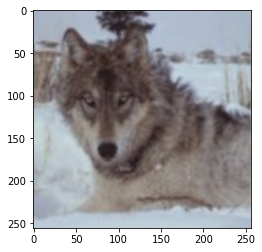

In [7]:
x = preprocess(PIL.Image.open("wolf2.jpeg"))
plt.imshow(x[0].permute(1, 2, 0));


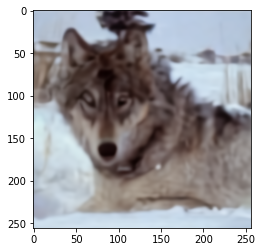

In [8]:
z = ae.encode(x)
x_rec = ae.decode(z)

plt.imshow(x_rec[0].permute(1, 2, 0).detach().numpy());

In [9]:
with open("imagenet1000_clsidx_to_labels.txt") as f:
    data = f.read()
imnet_classes = eval(data.replace("\n", ""))

In [10]:
out = model(x)
for idx in reversed(out[0].argsort()[-6:]):
    print(idx, imnet_classes[int(idx)], float(out[0][int(idx)]))

tensor(269) timber wolf, grey wolf, gray wolf, Canis lupus 8.858163833618164
tensor(271) red wolf, maned wolf, Canis rufus, Canis niger 6.382272243499756
tensor(273) dingo, warrigal, warragal, Canis dingo 6.221120357513428
tensor(272) coyote, prairie wolf, brush wolf, Canis latrans 4.8015923500061035
tensor(270) white wolf, Arctic wolf, Canis lupus tundrarum 4.769579887390137
tensor(274) dhole, Cuon alpinus 3.8157968521118164


In [11]:
out = model(x_rec)
for idx in reversed(out[0].argsort()[-6:]):
    print(idx, imnet_classes[int(idx)], float(out[0][int(idx)]))

tensor(269) timber wolf, grey wolf, gray wolf, Canis lupus 9.01096248626709
tensor(271) red wolf, maned wolf, Canis rufus, Canis niger 6.666568756103516
tensor(273) dingo, warrigal, warragal, Canis dingo 6.598722457885742
tensor(272) coyote, prairie wolf, brush wolf, Canis latrans 5.126465797424316
tensor(270) white wolf, Arctic wolf, Canis lupus tundrarum 4.5674147605896
tensor(274) dhole, Cuon alpinus 4.055598258972168


In [12]:
class_target = 269

In [13]:
z = ae.encode(x).detach()
z.requires_grad = True
xp = ae.decode(z)


In [14]:
pred = model(xp)[0, class_target]

In [15]:
dzdxp = torch.autograd.grad((pred), z)[0]

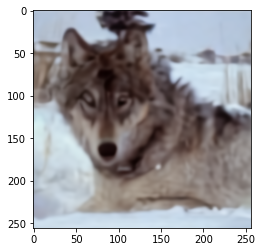

In [16]:
plt.imshow(xp[0].permute(1, 2, 0).detach().numpy());

In [17]:
xpp = ae.decode(z - dzdxp*0.0005)

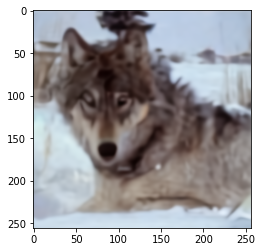

In [18]:
plt.imshow(xpp[0].permute(1, 2, 0).detach().numpy());

In [19]:
import attribution

In [20]:
params = attribution.compute_attribution(x, "latentshift", model, class_target, ae=ae, ret_params=True)


0 [0.9998779]
-0.1 [0.99986815]
-0.2 [0.9998505]
-0.30000000000000004 [0.9998355]
-0.4 [0.9998228]
-0.5 [0.9998087]
-1.0 [0.9997701]
-1.5 [0.9997483]
-2.0 [0.99972874]
-2.5 [0.99970967]
-3.0 [0.9996948]
-3.5 [0.99968207]
-4.0 [0.9996655]
-4.5 [0.9996482]
-5.0 [0.9996301]
-5.5 [0.9996119]
-6.0 [0.9995939]
-6.5 [0.9995788]
-7.0 [0.9995666]
-7.5 [0.9995604]
-8.0 [0.9995529]
-8.5 [0.99952483]
-9.0 [0.99949014]
-9.5 [0.9994955]
[0.9998779] -9.5 0
-8.55 [0.9995227]
-7.600000000000001 [0.9995586]
-6.650000000000002 [0.9995752]
-5.700000000000003 [0.9996056]
-4.7500000000000036 [0.9996393]
-3.8000000000000043 [0.9996724]
-2.850000000000005 [0.99969864]
-1.9000000000000057 [0.9997327]
-0.9500000000000064 [0.99977285]


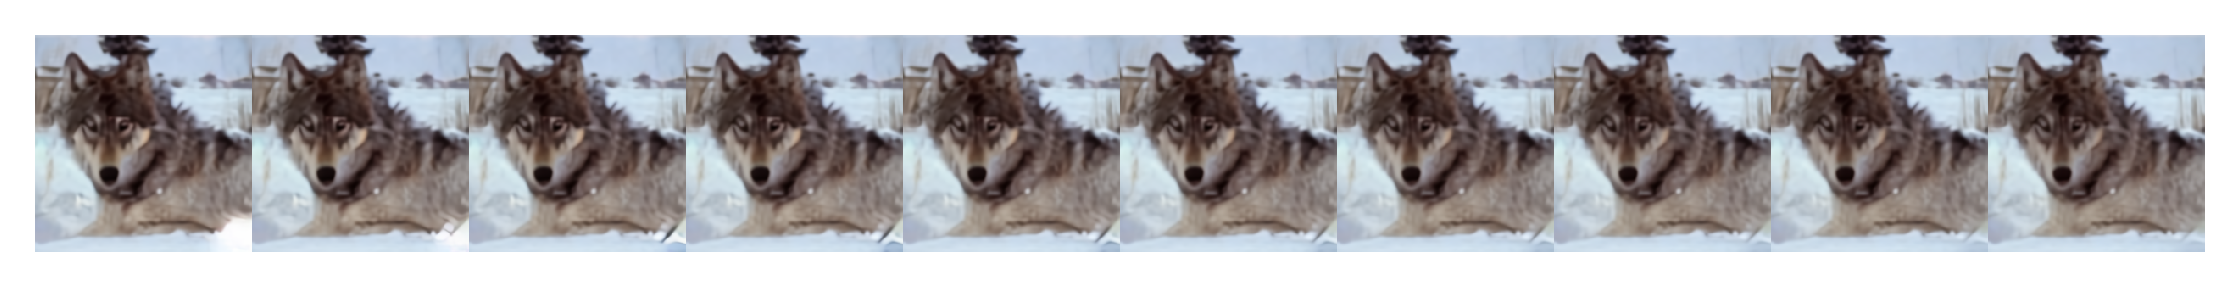

In [21]:
dimgs2 = [h.transpose(0,2,3,1) for h in params["dimgs"]]
dimgs = np.concatenate(dimgs2)
fig, ax = plt.subplots(1,1, figsize=(8,3), dpi=350)
plt.imshow(np.concatenate(dimgs,1), interpolation='none');
plt.axis('off');

In [22]:
%matplotlib inline
attribution.generate_video(x, model, class_target, ae, target_filename="test", border=False, show=True,
                           ffmpeg_path="ffmpeg", params=params)

0
10
ffmpeg -loglevel quiet -stats -y -i /tmp/gifsplanation/image-%d-a.png -c:v libx264 -vf scale=-2:256 -profile:v baseline -level 3.0 -pix_fmt yuv420p 'test.mp4'
b''


frame=  120 fps=0.0 q=-1.0 Lsize=      64kB time=00:00:04.76 bitrate= 109.4kbits/s speed=33.5x    
